**Import HMM module and all other dependencies**

In [1]:
import os
from matplotlib import pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import autograd.numpy as np
import sys
import autograd.numpy.random as npr
npr.seed(0)

sys.path.insert(1,'/Users/cecelia/Desktop/Shuler Lab/ssm')
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

os.chdir('/Users/cecelia/Desktop/Shuler Lab/kyoani')
import utils
from behavior import BehaviorAnalysis
import sys
sys.path.insert(1,'../hmmlearn')
from hmmlearn import hmm

import matplotlib.colors as mcolors
color_two_states = ["#C2EFEB","#4392F1","#FF9FB2", "#FFE787","#A5907E"]
cmap_custom = mcolors.ListedColormap(color_two_states)

In [2]:
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cols = ["#e74c3c", "#15b01a", "#7e1e9c", "#3498db", "#f97306","#7209b7", "#f72585"]
cmap = gradient_cmap(colors)

**Load the pre-processed behavioral data**

In [3]:
global task_type, has_block, task_params
task_type = "regular"
has_block = False
task_params = "old_params"
# task_params = "param_v2"
global m1, p1, m2, p2, bg1, bg2
# old params
# m1 = 1
# m2 = 3

# version 2 params
m1 = 1.2
m2 = 3.3

p1 = p2 = 0.9
bg1 = bg2 = 2

optimal_wait_short = utils.get_optimal_time(m1, p1, bg1)
print(f'optimal wait time for short timescape is {optimal_wait_short}')
optimal_wait_long = utils.get_optimal_time(m2, p2, bg2)
print(f'optimal wait time for long timescape is {optimal_wait_long}')
optimal_wait = [optimal_wait_short, optimal_wait_long]

params_dict = {"m1": m1, "p1": p1, "bg1": bg1, "m2": m2, "p2": p2, "bg2": bg2}
need_checkpoint = False

path = os.path.normpath('/Users/cecelia/Desktop/Shuler Lab/kyoani')
os.chdir(path)
beh = BehaviorAnalysis("exp1", optimal_wait, params_dict, task_type=task_type,
                           has_block=has_block, task_params=task_params)
utils.set_analysis_path(has_block, task_params)
with open('mice_data_mar2024.pkl', 'rb') as file:
            mice = pickle.load(file)
            beh.mice = mice


optimal wait time for short timescape is 1.6810506566604126
optimal wait time for long timescape is 3.0644152595372107
running on a mac
running on a mac


<b>Select animal IDs</b>

In [ ]:
'''
Some data structures notes: 
beh.animal_assignment: a dictionary 
    KEYS: animal IDS
    VALUES: 
        timescape': {'default': ['short', 's'], 'change': ['long', 'l']}, 
        'sex': ['F'], 
        'single_housed': ['T']
    ^ Can access these attributes by: cohort_assignment[animal ID][0][value]
beh.mice: a list of object 'mice'
    mouse = beh.mice[index of list] # each individual mice
    mouse.name # mouse ID
    mouse.default # long/short assignment 
    mouse.all_holding_l / mouse.all_holding_s 
        -> trial by trial lick time concatenated all sessions
    mouse.all_holding_l_list / mouse.all_holding_s_list 
        -> list of list, each sublist has one session's trial by trial lick time
        -> sublist is in form of pandas series
            mouse.all_holding_l/s_list[session index].values
            mouse.all_holding_l/s_list[session index].index
    mouse.all_holding_l_index/ mouse.all_holding_s_index
        -> index of the session cutoff in the all_holding_l_list / all_holding_s_list 
    # REWARD HISTORY
    mouse.self.all_rewarded_s_list / mouse.self.all_rewarded_l_list
        -> list of list, each sublist has one session's trial by reward history (binary)
    mouse.self.all_rewarded_s_index / mouse.self.all_rewarded_l_index
        -> index of the session cutoff in the all_holding_l_list/ all_holding_s_list
    mouse.self.all_rewarded_s / mouse.self.all_rewarded_l
        -> all trials reward history

'''


***Organize data in a data frame***

In [4]:
# can be later be organized in a function 
num_mice = 10  #ZG020 -> ZG029
mouse_list = ['ZG020',
            'ZG021',
            'ZG022',
            'ZG023',
            'ZG024',
            'ZG025',
            'ZG026',
            'ZG027',
            'ZG028',
            'ZG029']
temp_list = []
master_list = []
for id in range(0,num_mice): # hard code ten for now
    curr_mice = mice[id]
    curr_mice_id = curr_mice.name
    cohort = curr_mice.default
    total_sess= len(curr_mice.default_sessions)
    trial_number = []
    if cohort == 'short':
        all_licks = curr_mice.all_holding_s
        all_reward = curr_mice.all_rewarded_s
    else:
        all_licks = curr_mice.all_holding_l
        all_reward = curr_mice.all_rewarded_l
    prev_session_len = 0
    for session_id in range(0,total_sess):
        # get every trial's holding time
        if cohort == 'short':
            lick_list = list(curr_mice.all_holding_s_list[session_id].values)
            session_index= curr_mice.all_holding_s_index[session_id]
            reward_list = curr_mice.all_rewarded_s_list[session_id]
        else:
            lick_list = list(curr_mice.all_holding_l_list[session_id].values)
            session_index = curr_mice.all_holding_l_index[session_id] 
            reward_list = curr_mice.all_rewarded_l_list[session_id]
        
        prev_licks = [0] + lick_list[:-1]
        # print(f'prev licks len {len(prev_licks)}')
        # print(f'licks len {len(lick_list)}')
        prev_rewards = [0] + reward_list[:-1]
        # print(f'prev reward len {len(prev_rewards)}')
        # print(f'reward len {len(reward_list)}')
        new_row_temp = {'mouse': curr_mice_id,'cohort': cohort, 'session':session_id,'licktime': lick_list, 'previous lick': prev_licks, 'reward history':reward_list, 'previous reward': prev_rewards, 'session length':session_index - prev_session_len}
        trial_number = trial_number + [session_index]
        prev_session_len = session_index
        temp_list.append(new_row_temp)
    new_row_master = {'mouse': curr_mice_id,'cohort': cohort,'all_licks': all_licks,'session_num':total_sess, 'trial_num':trial_number,'all_reward':all_reward}
    master_list.append(new_row_master)
df_individual_session = pd.DataFrame(temp_list)
df_by_mouse = pd.DataFrame(master_list)

In [25]:
df_individual_session

mouse cohort  session                                           licktime  \
0    ZG026   long        0  [1.0395071506500244, 3.4789156913757324, 0.731...   
1    ZG026   long        1  [0.8544578552246094, 1.3025720119476318, 1.640...   
2    ZG026   long        2  [1.7730646133422852, 2.717624425888061, 0.4204...   
3    ZG026   long        3  [4.655585289001465, 1.1242406368255615, 3.0058...   
4    ZG026   long        4  [0.5175294876098633, 2.1217703819274902, 5.379...   
..     ...    ...      ...                                                ...   
370  ZG029  short       35  [12.4596266746521, 7.101715564727783, 8.857118...   
371  ZG029  short       36  [1.2458899021148682, 0.0788826942443847, 0.828...   
372  ZG029  short       37  [11.078718900680542, 0.3663384914398193, 6.559...   
373  ZG029  short       38  [7.465791940689087, 1.1168854236602783, 0.5603...   
374  ZG029  short       39  [11.456169843673706, 7.636866569519043, 0.3678...   

                                         previous lick  \
0    [0, 1.0395071506500244, 3.4789156913757324, 0....   
1    [0, 0.8544578552246094, 1.3025720119476318, 1....   
2    [0, 1.7730646133422852, 2.717624425888061, 0.4...   
3    [0, 4.655585289001465, 1.1242406368255615, 3.0...   
4    [0, 0.5175294876098633, 2.1217703819274902, 5....   
..                                                 ...   
370  [0, 12.4596266746521, 7.101715564727783, 8.857...   
371  [0, 1.2458899021148682, 0.0788826942443847, 0....   
372  [0, 11.078718900680542, 0.3663384914398193, 6....   
373  [0, 7.465791940689087, 1.1168854236602783, 0.5...   
374  [0, 11.456169843673706, 7.636866569519043, 0.3...   

                                        reward history  \
0    [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, ...   
1    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...   
3    [1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...   
4    [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, ...   
..                                                 ...   
370  [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, ...   
371  [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...   
372  [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
373  [1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, ...   
374  [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, ...   

                                       previous reward  session length  
0    [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, ...             230  
1    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...             327  
2    [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...             441  
3    [0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, ...             224  
4    [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, ...             163  
..                                                 ...             ...  
370  [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, ...             404  
371  [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...             448  
372  [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...             452  
373  [0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, ...             186  
374  [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, ...             303  

[375 rows x 8 columns]

**Inividual mice & individual session visualization**

In [5]:
saving= False
# extract single mouse data
for id in range(0,len(mouse_list)):
    mouse = mouse_list[id]
    df_mouse = df_individual_session[df_individual_session['mouse'] == mouse]

    for session in df_mouse['session']:
        row = df_mouse.loc[df_mouse['session'] == session]
        cohort = row['cohort'].values[0]
        sess_licks = row['licktime'].values[0]
        sess_reward = row['reward history'].values[0]

        rewarded_indices = [index for index,value in enumerate(sess_reward) if value == 1]
        unrewarded_indices = [index for index,value in enumerate(sess_reward) if value == 0]
        rewarded_licktime = [sess_licks[index] for index in rewarded_indices]
        unrewarded_licktime = [sess_licks[index] for index in unrewarded_indices]

        fig, ax = plt.subplots(figsize=(40, 6))
        ax.scatter(rewarded_indices,rewarded_licktime,c='red')
        ax.scatter(unrewarded_indices,unrewarded_licktime,c='black')
        ax.set_title(f'{mouse} hold time {cohort}')
        ax.set_xlabel("trial")
        ax.set_xlim([0,len(sess_licks)])
        ax.set_ylabel("holding time(s)")
        ax.legend(['rewarded','unrewarded'])
        if saving:
            save_path = f'/Users/cecelia/Desktop/Shuler Lab/licktime_analysis/figures/{mouse}/'
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path + f'{mouse}_sess{session}.png')
        plt.close()

**Individual mice all sessions visualization**

In [115]:
mouse_list

['ZG020',
 'ZG021',
 'ZG022',
 'ZG023',
 'ZG024',
 'ZG025',
 'ZG026',
 'ZG027',
 'ZG028',
 'ZG029']

all trials length 11125


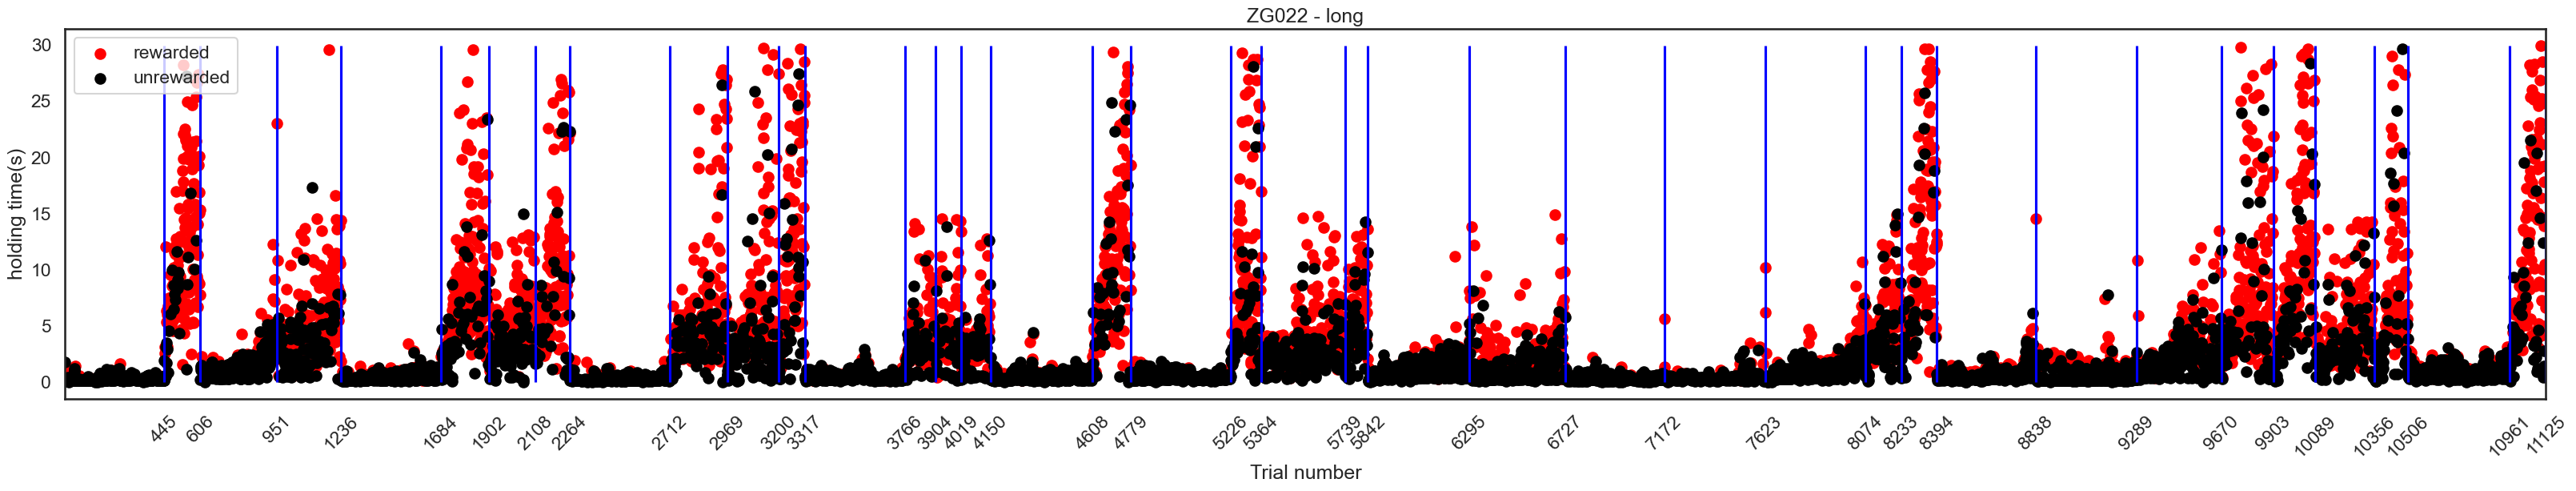

In [6]:
chosen_mouse = 'ZG022'
id = mouse_list.index(chosen_mouse)
mouse = mouse_list[id]
row = df_by_mouse[df_by_mouse['mouse'] == mouse]
fig, ax = plt.subplots(figsize=(40, 6))
cohort = row['cohort'].values[0]
all_licks = np.array(row['all_licks'].values[0])
print(f"all trials length {len(all_licks)}")
all_reward = np.array(row['all_reward'].values[0])
sess_cutoff = row['trial_num'].values[0]
rewarded_indices = [index for index,value in enumerate(all_reward) if value == 1]
unrewarded_indices = [index for index,value in enumerate(all_reward) if value == 0]
rewarded_licktime = all_licks[rewarded_indices]
unrewarded_licktime = all_licks[unrewarded_indices]

ax.scatter(rewarded_indices,rewarded_licktime,c='red')
ax.scatter(unrewarded_indices,unrewarded_licktime,c='black')
ax.vlines(sess_cutoff, ymin = 0, ymax = max(all_licks),color='blue')
ax.set_title(f'{mouse} - {cohort}')
ax.set_xlabel("Trial number")
ax.set_xlim([0,len(all_licks)])
ax.set_xticks(sess_cutoff)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("holding time(s)")
ax.legend(['rewarded','unrewarded'])

**plot session average and session adjusted optimal together**

Text(0.5, 1.0, 'Wait Time optimal vs. average per session ZG022 long')

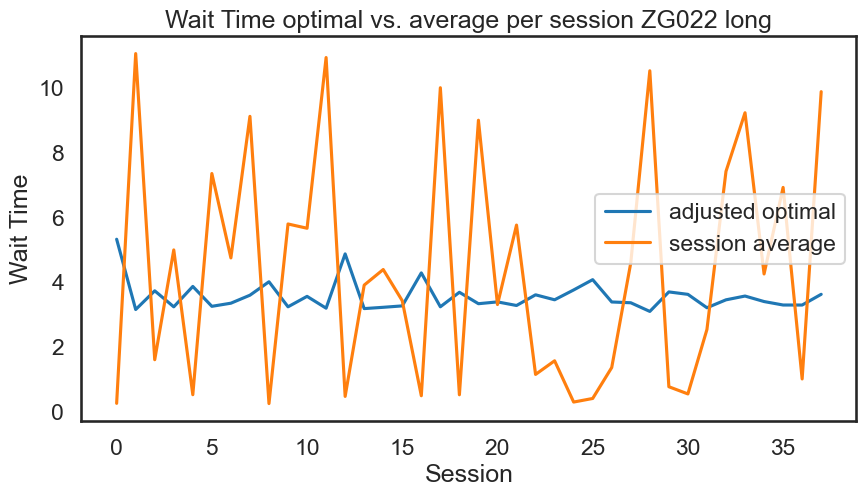

In [7]:
obj_list = []
for mouse_ in mice:
    obj_list.append(mouse_.name)
curr_mice = mice[obj_list.index(chosen_mouse)]
if curr_mice.default == 'short':
    session_avg =curr_mice.holding_s_mean[:curr_mice.default_session_num]
else:
    session_avg =curr_mice.holding_l_mean[:curr_mice.default_session_num]
# plot session average and session adjusted optimal together
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(curr_mice.session_adjusted_optimal[0:len(session_avg)],label = 'adjusted optimal')
ax.plot(session_avg, label = 'session average')
ax.legend()
ax.set_ylabel('Wait Time')
ax.set_xlabel('Session')
ax.set_title(f'Wait Time optimal vs. average per session {curr_mice.name} {curr_mice.default}')

**Population mice visualization**

In [67]:
# saving= False
# for id in range(0,len(mouse_list)): #hard code ten for now
#     mouse = mouse_list[id]
#     row = df_by_mouse[df_by_mouse['mouse'] == mouse]
#     fig, ax = plt.subplots(figsize=(40, 6))
#     cohort = row['cohort'].values[0]
#     all_licks = np.array(row['all_licks'].values[0])
#     all_reward = np.array(row['all_reward'].values[0])
#     sess_cutoff = row['trial_num'].values[0]
#     rewarded_indices = [index for index,value in enumerate(all_reward) if value == 1]
#     unrewarded_indices = [index for index,value in enumerate(all_reward) if value == 0]
#     rewarded_licktime = all_licks[rewarded_indices]
#     unrewarded_licktime = all_licks[unrewarded_indices]

#     ax.scatter(rewarded_indices,rewarded_licktime,c='red')
#     ax.scatter(unrewarded_indices,unrewarded_licktime,c='black')
#     ax.vlines(sess_cutoff, ymin = 0, ymax = max(all_licks),color='blue')
#     ax.set_title(f'{mouse} - {cohort}')
#     ax.set_xlabel("trial")
#     ax.set_xlim([0,len(all_licks)])
#     ax.set_ylabel("holding time(s)")
#     ax.legend(['rewarded','unrewarded'])
#     save_path = f'/Users/cecelia/Desktop/Shuler Lab/licktime_analysis/figures/{mouse}/'
#     if saving:
#         if not os.path.exists(save_path):
#             os.makedirs(save_path)
#         plt.savefig(save_path + f'{mouse}_all_licks.png')
#         plt.close()
#     else:
#         plt.close()

**Gaussian HMM for individual mice**

In [8]:
# id = 2
# mouse = mouse_list[id]
df_mouse = df_individual_session[df_individual_session['mouse'] == mouse]
print(mouse)
X = []
# counter = 0
for session in df_mouse['session']:
    rows = df_mouse.loc[df_mouse['session'] == session]
    cohort = rows['cohort'].values[0]
    sess_licks = np.array(rows['licktime'].values[0])
    # sess_reward = np.array(rows['reward history'].values[0])
    prev_licks = np.array(rows['previous lick'].values[0])
    prev_reward = np.array(rows['previous reward'].values[0])
    # counter = counter + len(sess_licks)
    # print(counter)
    # this_session_matrix = np.concatenate((sess_licks.reshape(-1,1), prev_licks.reshape(-1,1),prev_reward.reshape(-1,1)), axis=1)
    this_session_matrix = np.concatenate((sess_licks.reshape(-1,1), prev_licks.reshape(-1,1),prev_reward.reshape(-1,1)), axis=1)
    if len(X) == 0:
         X = this_session_matrix
    else:
        X = np.vstack((X,this_session_matrix))

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
# print(counter)

ZG022


  0%|          | 0/50 [00:00<?, ?it/s]

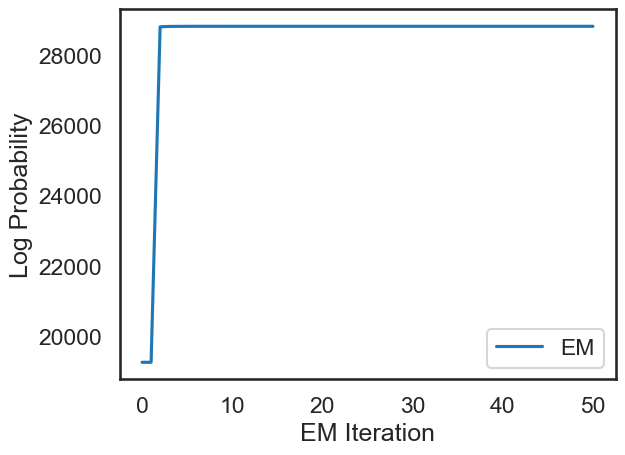

  0%|          | 0/50 [00:00<?, ?it/s]

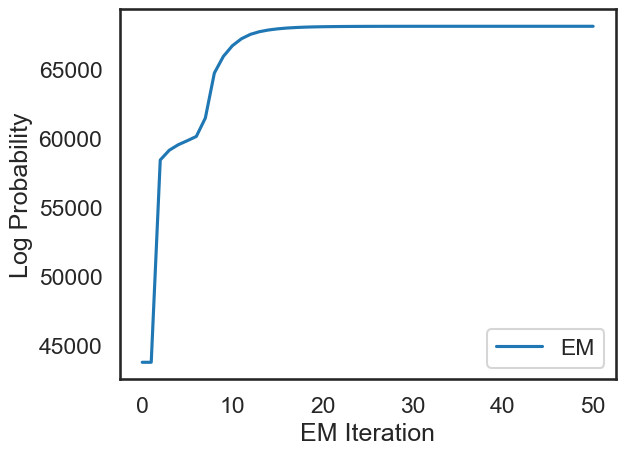

  0%|          | 0/50 [00:00<?, ?it/s]

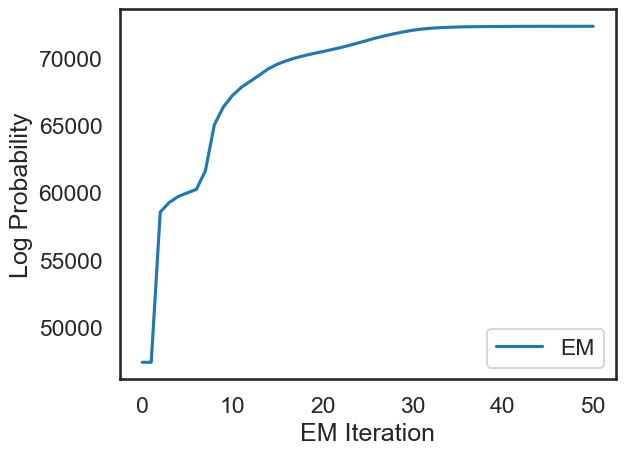

  0%|          | 0/50 [00:00<?, ?it/s]

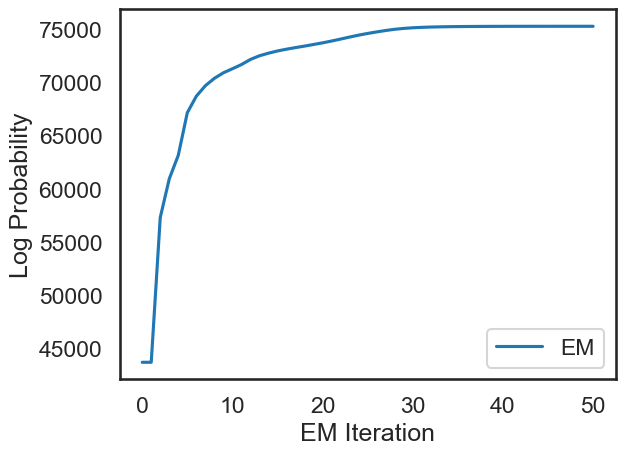

  0%|          | 0/50 [00:00<?, ?it/s]

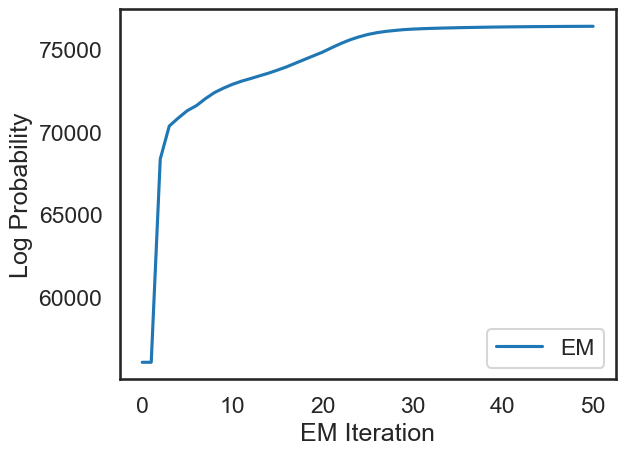

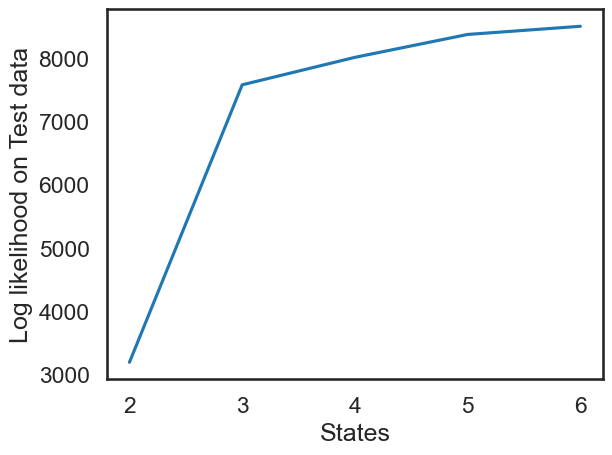

In [9]:
lls = []

num_iter = 50

time_bins = len(X)   # number of time bins
num_of_states = 5    # number of discrete states
obs_dim = 3       # dimensionality of observation

models = []
states = [2,3,4,5,6]
for n_components in states:     
    model = ssm.HMM(n_components, obs_dim,observations="gaussian",transitions="inputdriven")
    score = model.fit(X_train,method="em", num_iters=num_iter, init_method="kmeans")  
    models.append(model)
    lls.append(model.log_likelihood(X_test))
    plt.plot(score, label="EM")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()
    plt.close()
plt.plot(lls)
plt.xlabel("States")
plt.xticks(np.arange(0,num_of_states),["2","3","4","5","6"])
plt.ylabel("Log likelihood on Test data")
plt.show()
# plt.close()

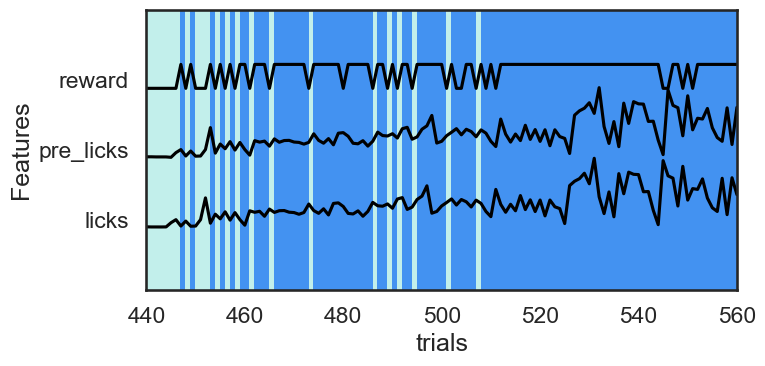

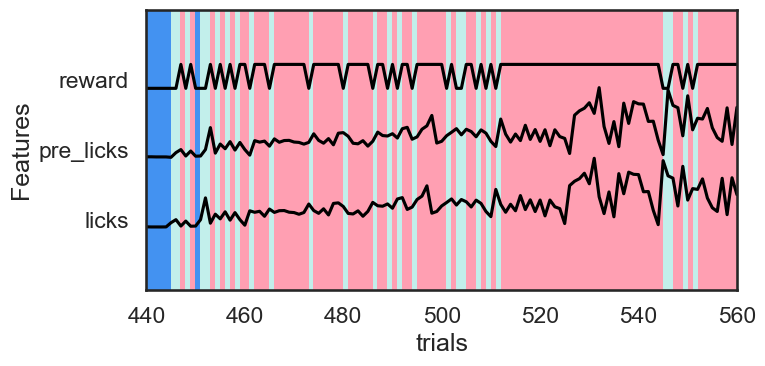

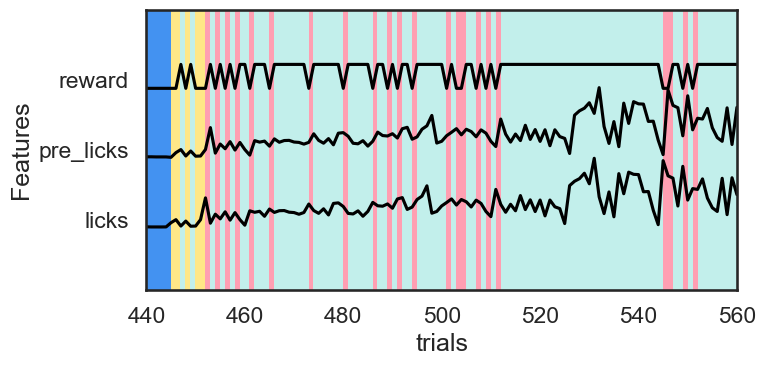

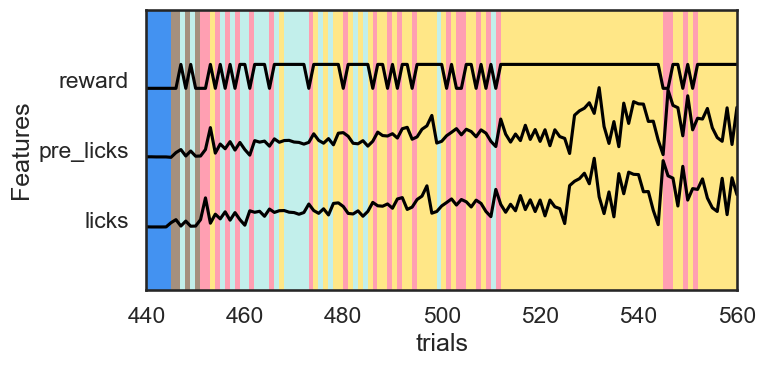

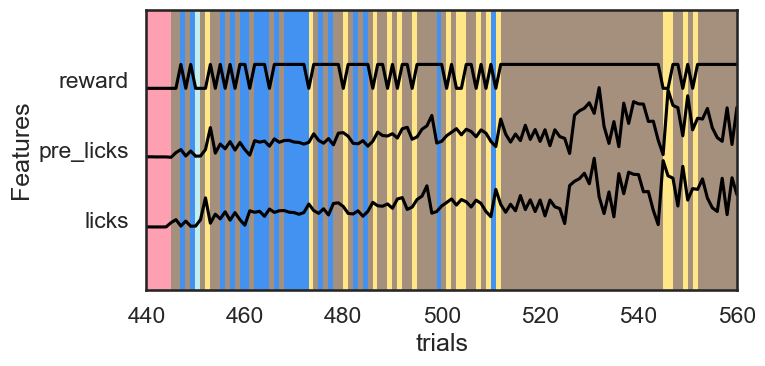

In [10]:
for model in models:
    most_likely_states = model.most_likely_states(X)
    lim = 1.05 * abs(X).max()
    plt.figure(figsize=(8, 4))
    plt.subplot()
    for d in range(obs_dim):
        plt.plot(X[:,d] + lim * d, '-k')
        
    plt.imshow(most_likely_states[None,:], 
            aspect="auto", cmap=cmap_custom,
            vmin=0, vmax=len(color_two_states)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    plt.xlim(440,560)
    plt.ylabel("Features")
    tick_position = lim * np.arange(obs_dim)
    plt.yticks(tick_position,["licks", "pre_licks", "reward"])
    plt.xlabel("trials")

    plt.tight_layout()

In [11]:
states = [2,3,4,5,6]

/Users/cecelia/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/cecelia/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


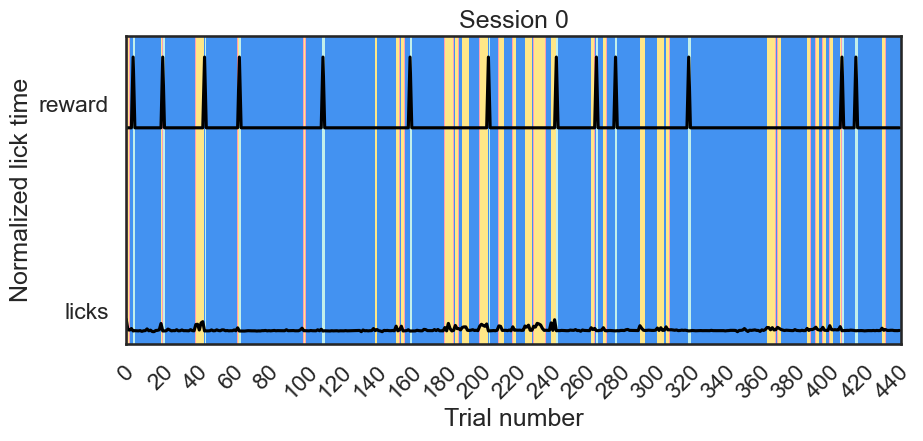

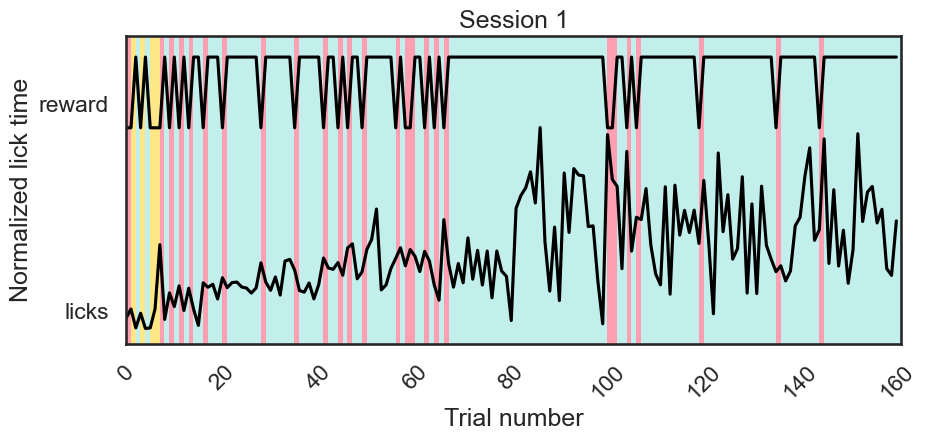

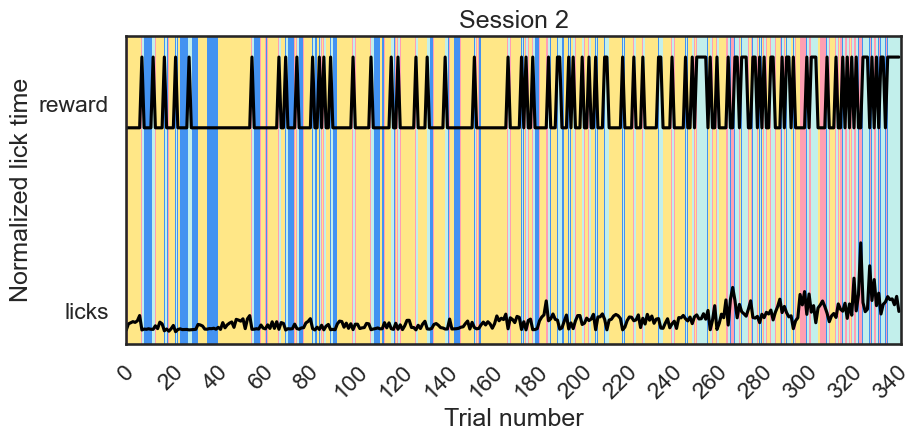

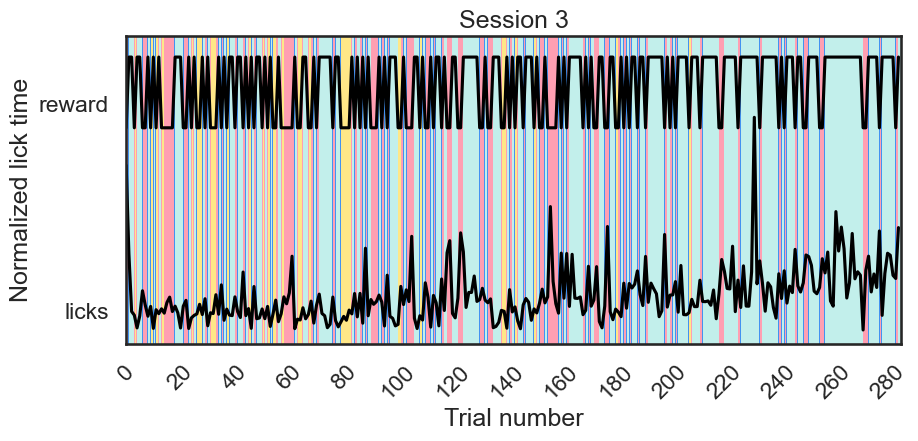

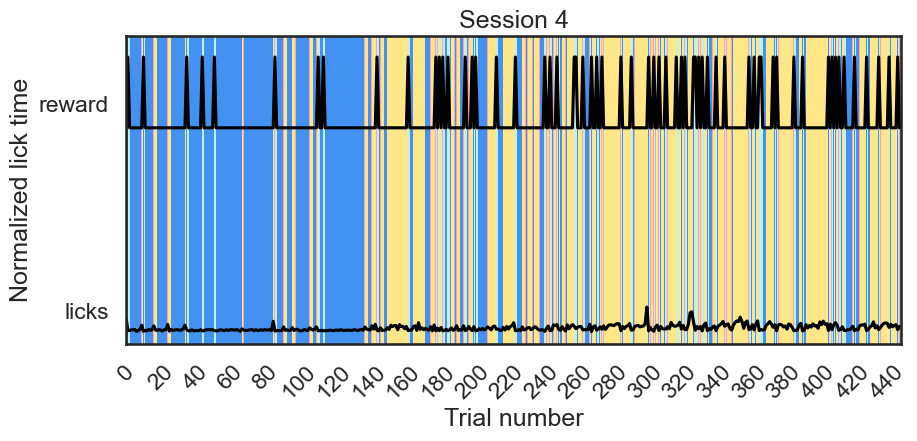

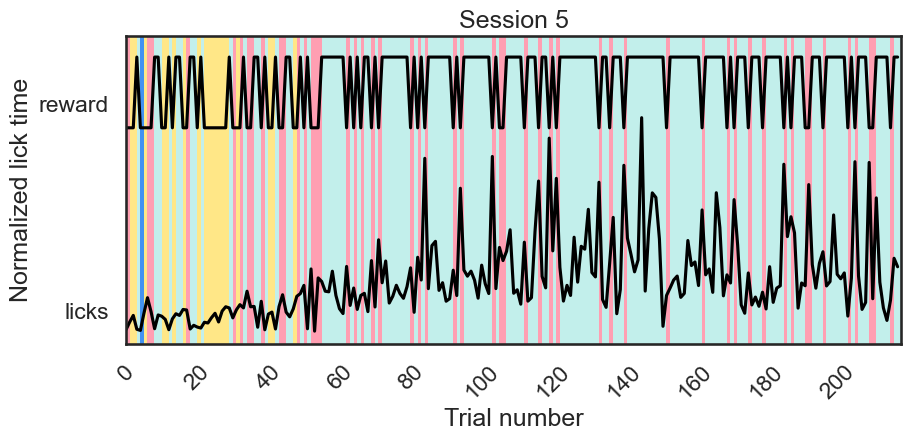

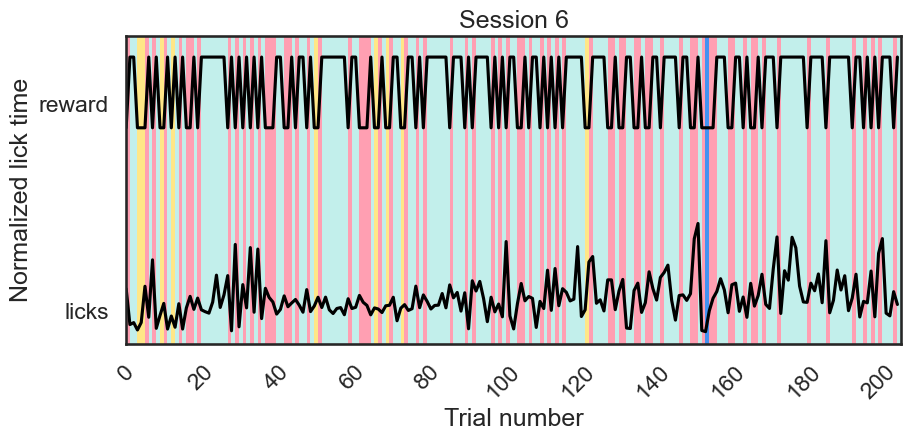

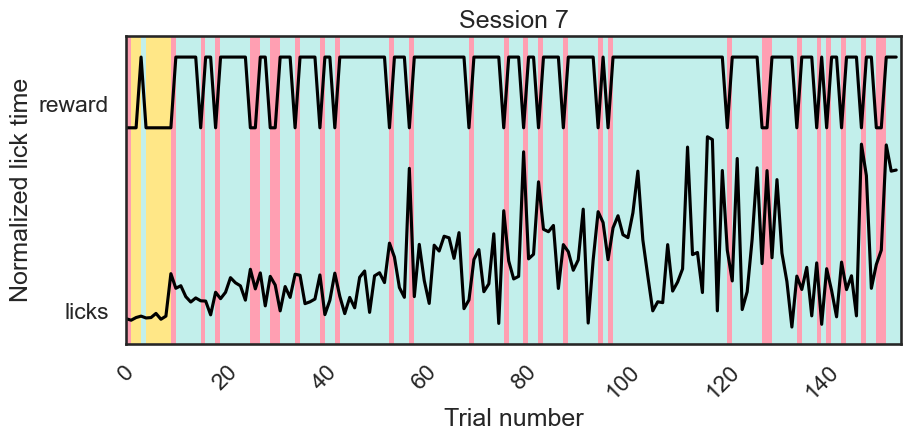

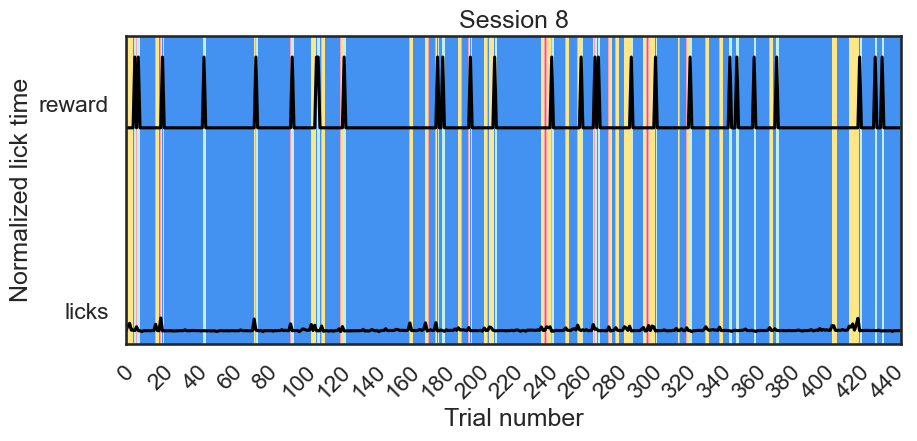

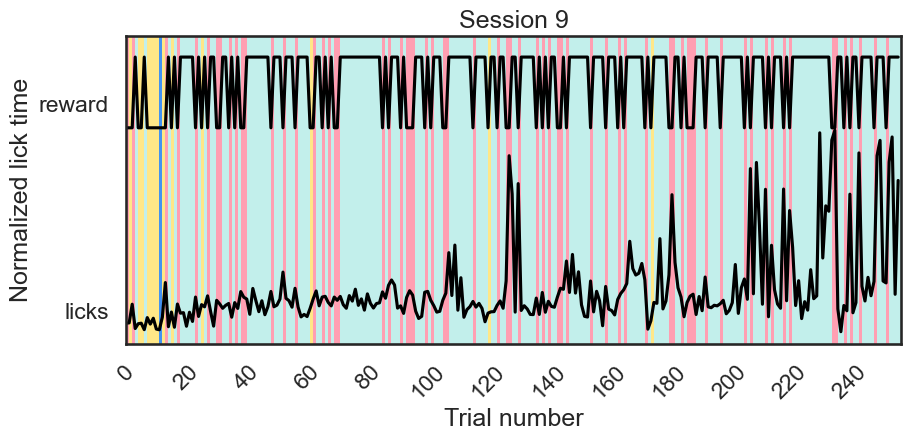

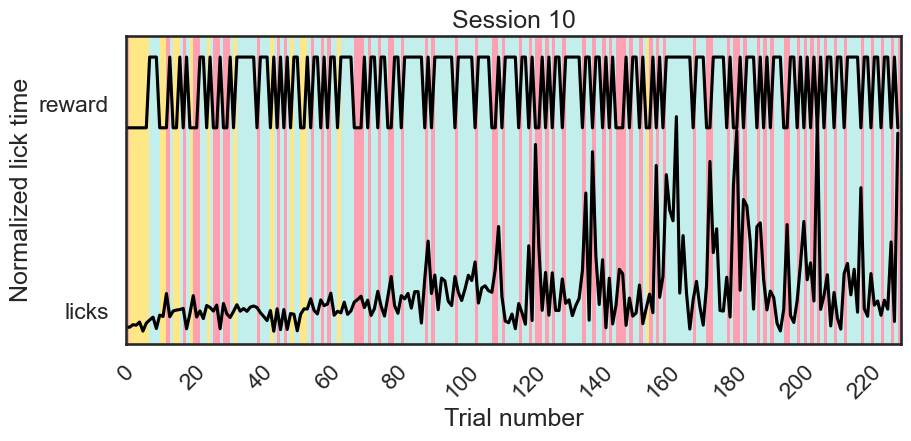

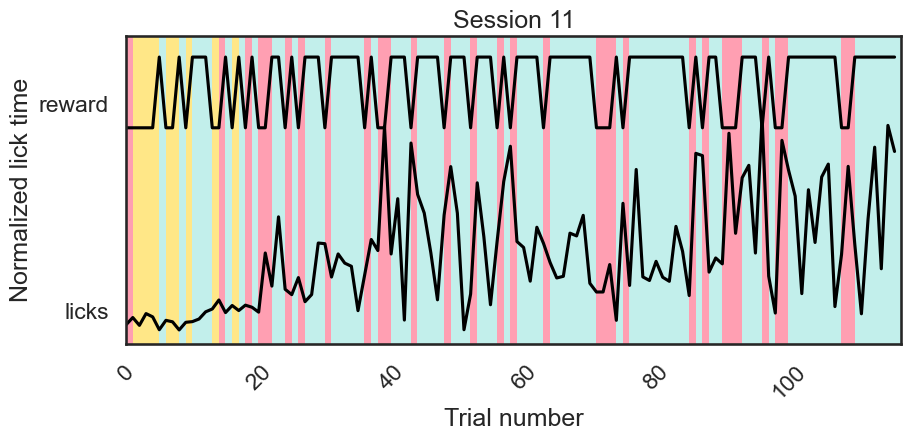

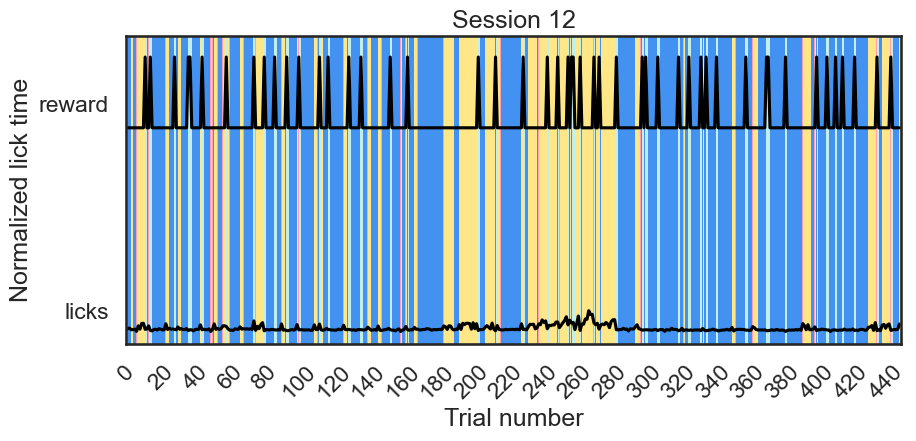

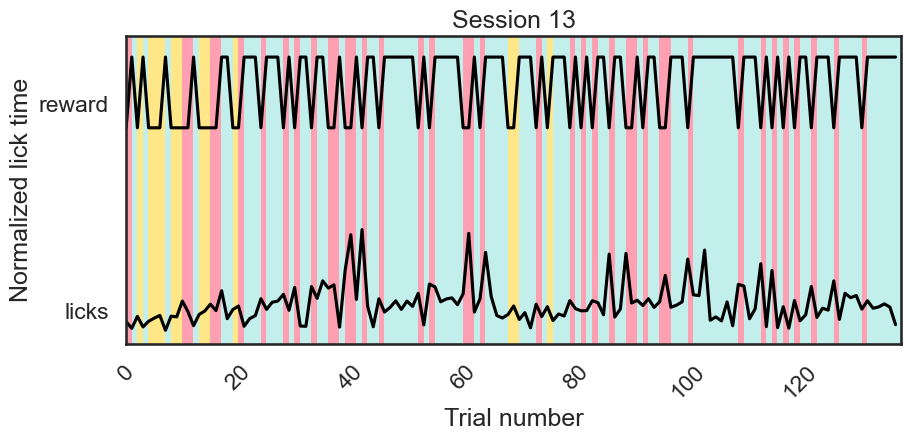

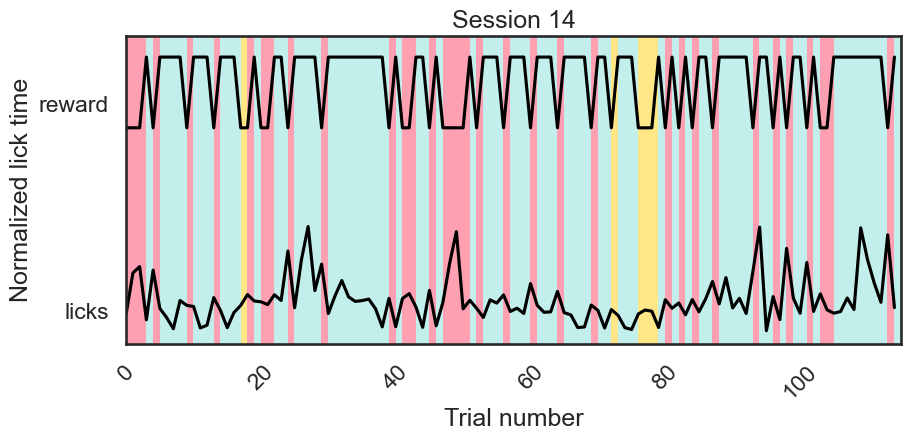

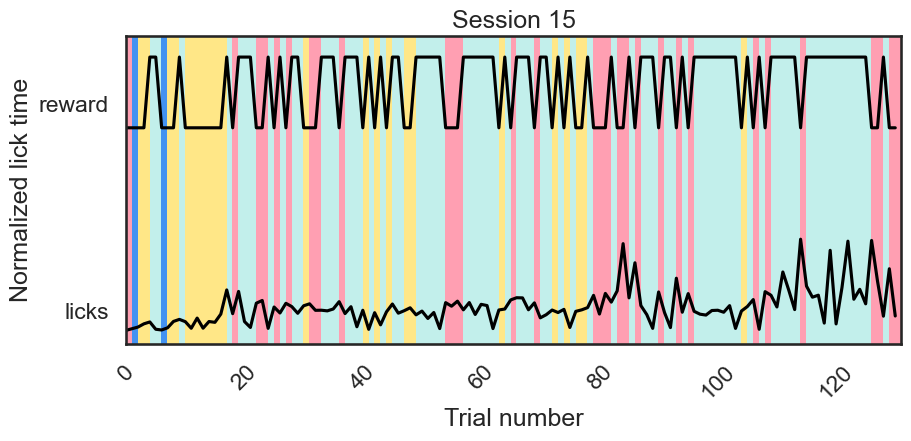

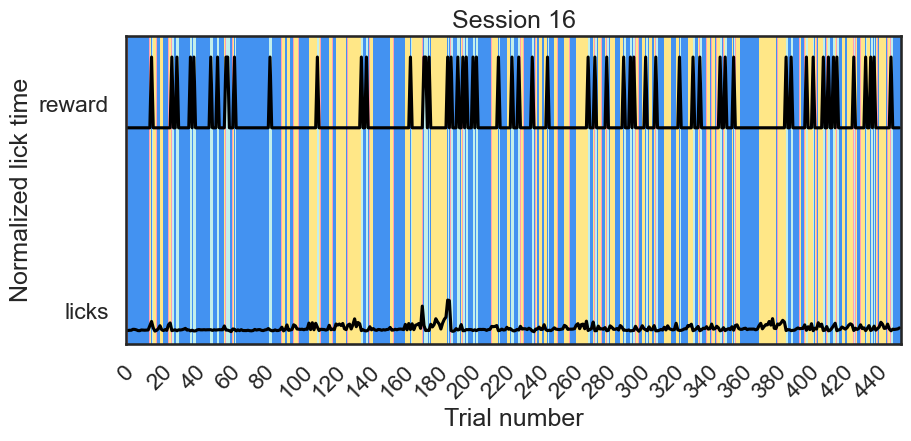

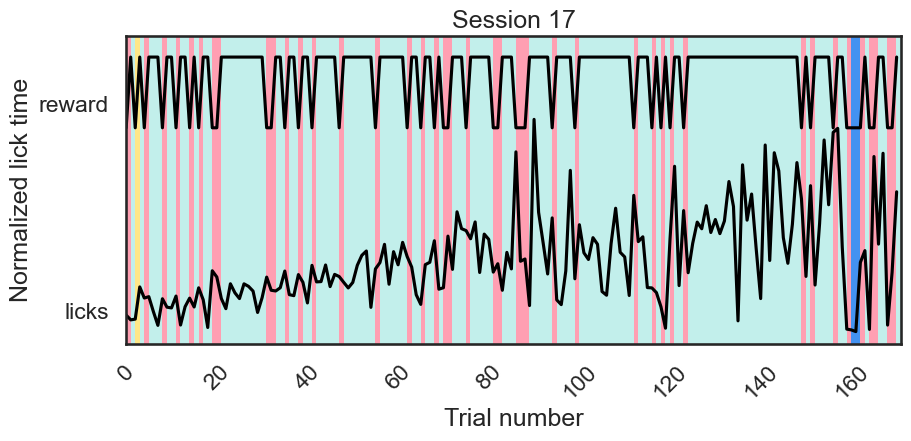

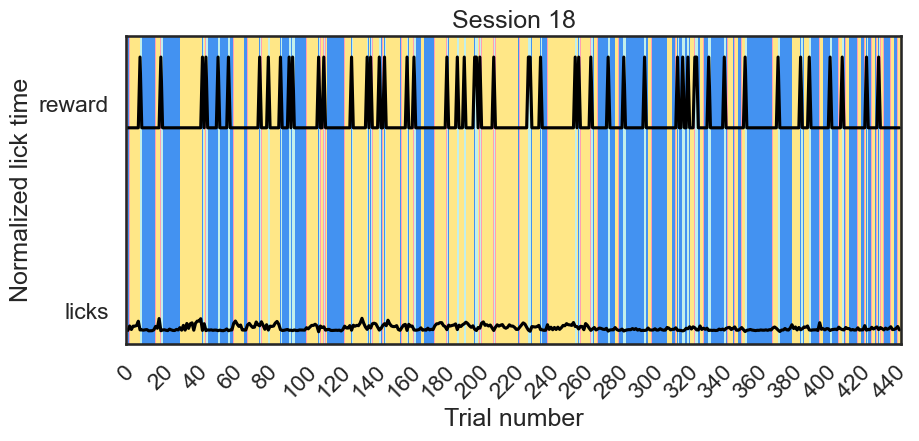

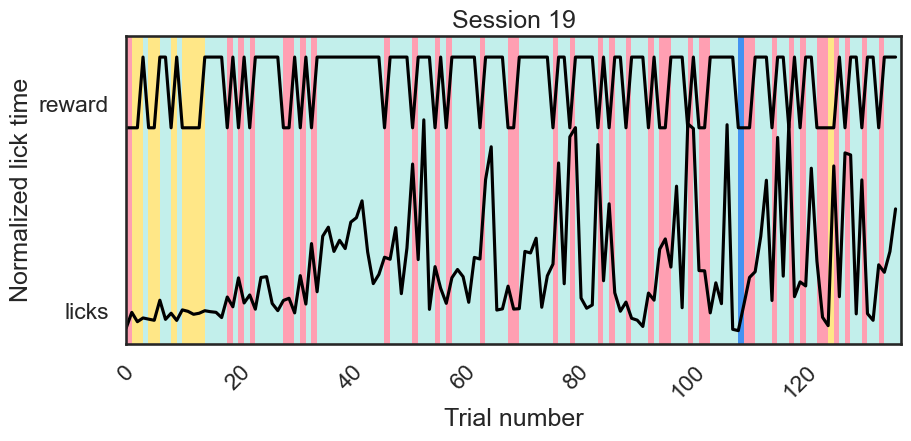

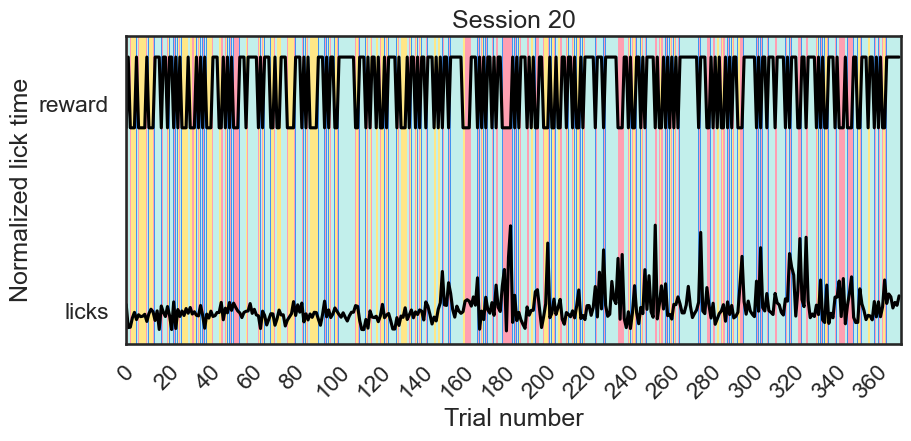

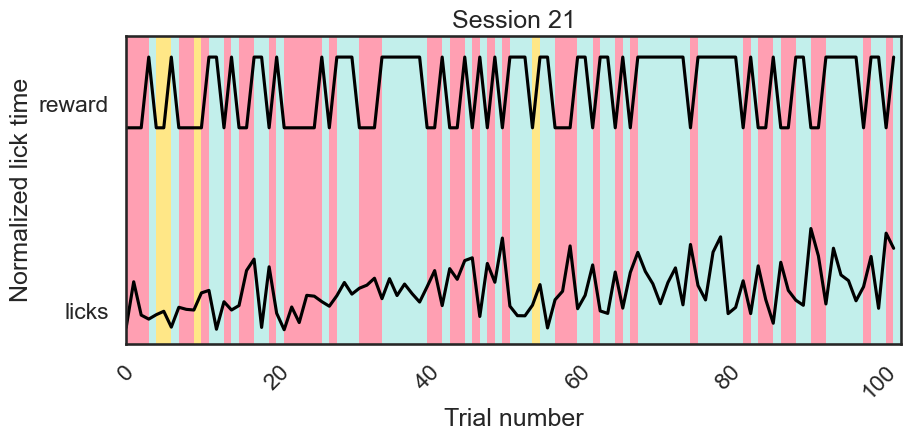

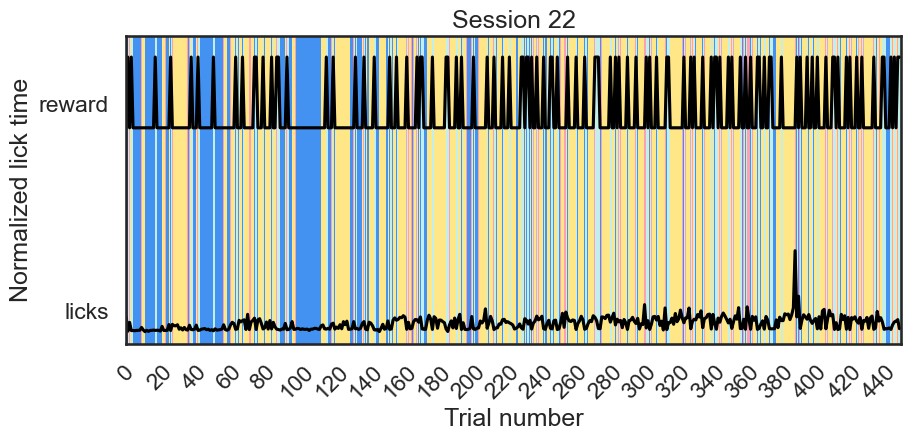

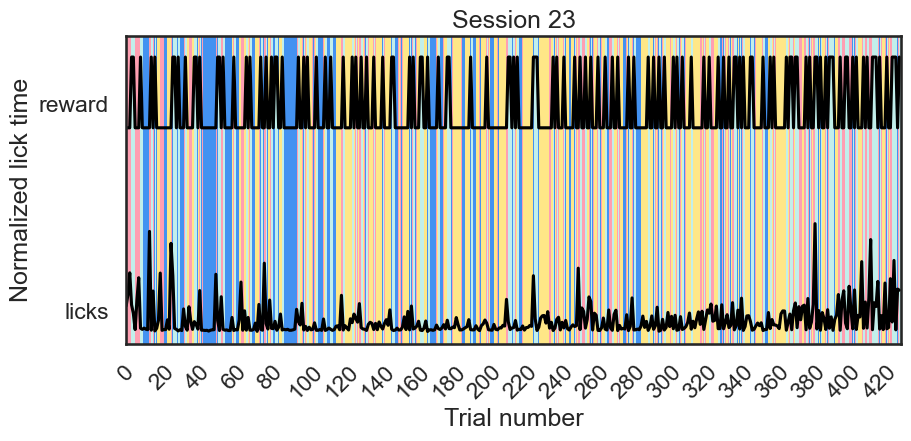

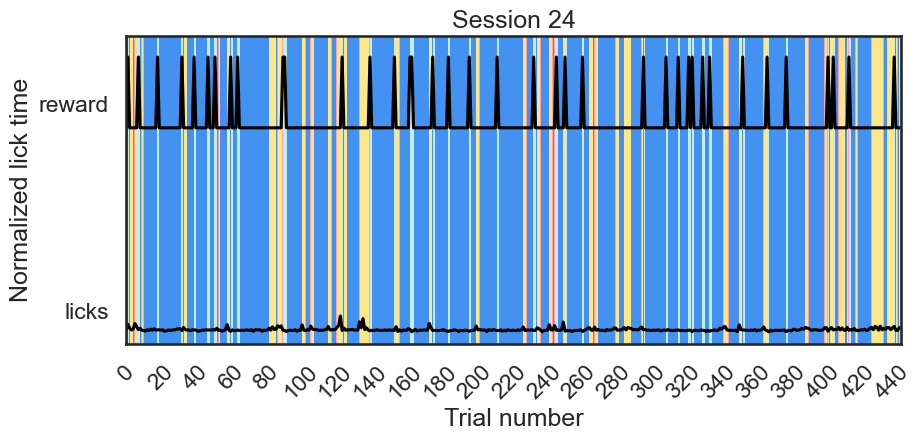

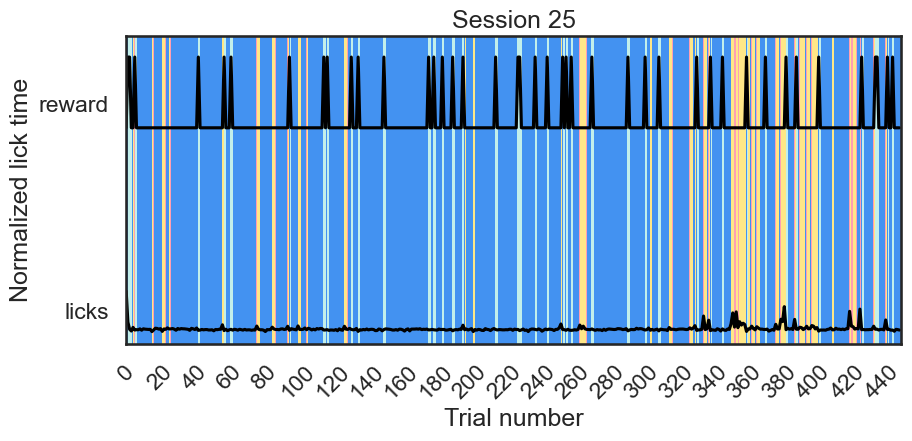

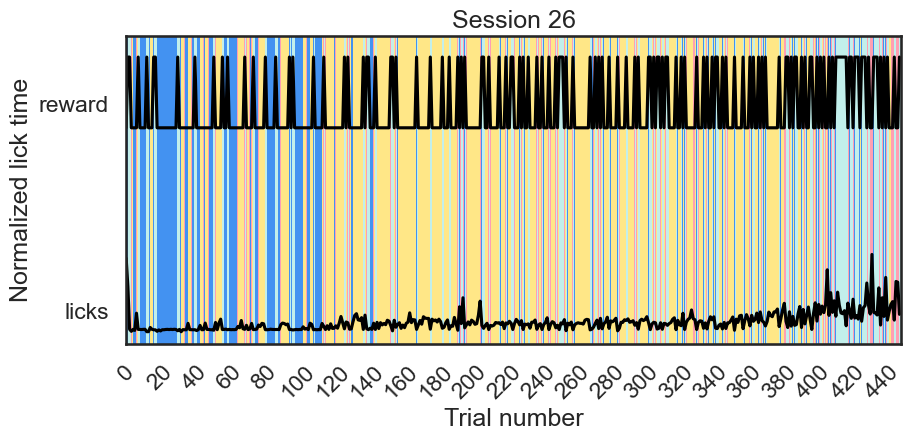

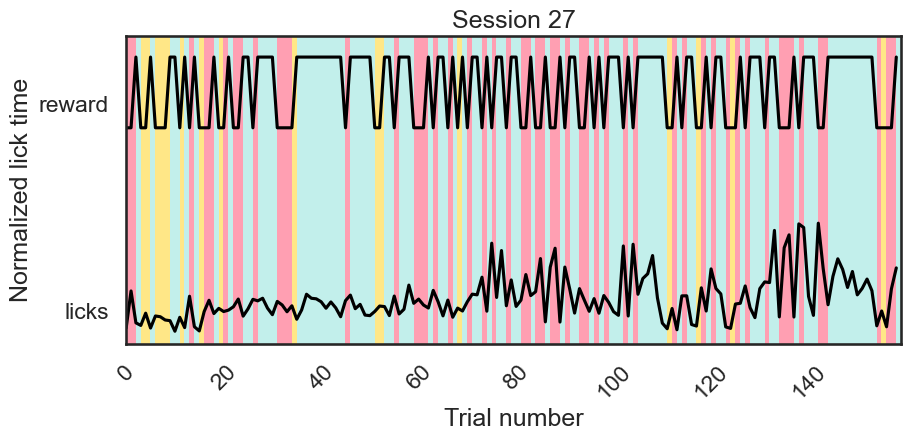

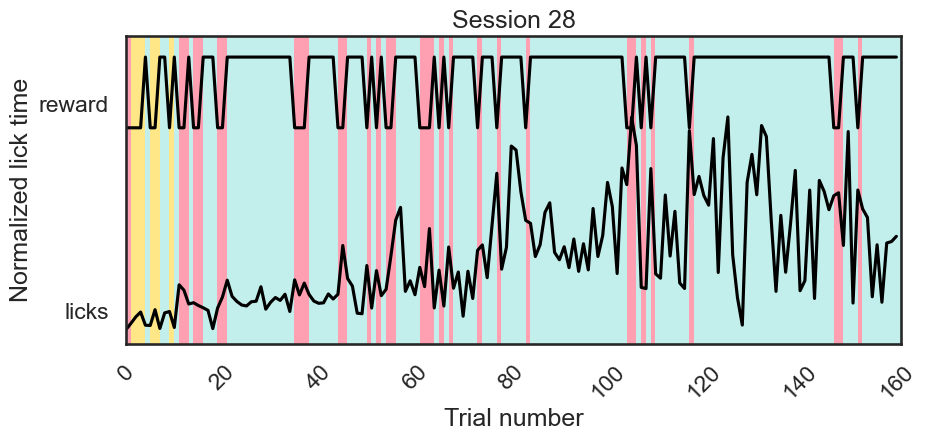

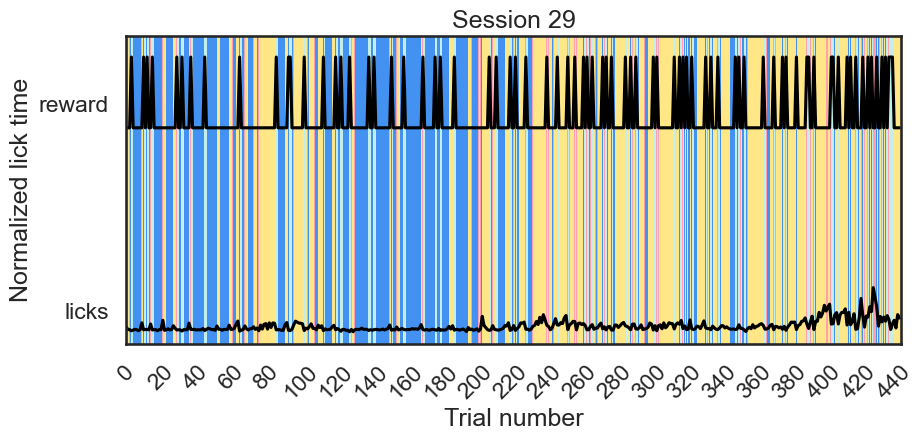

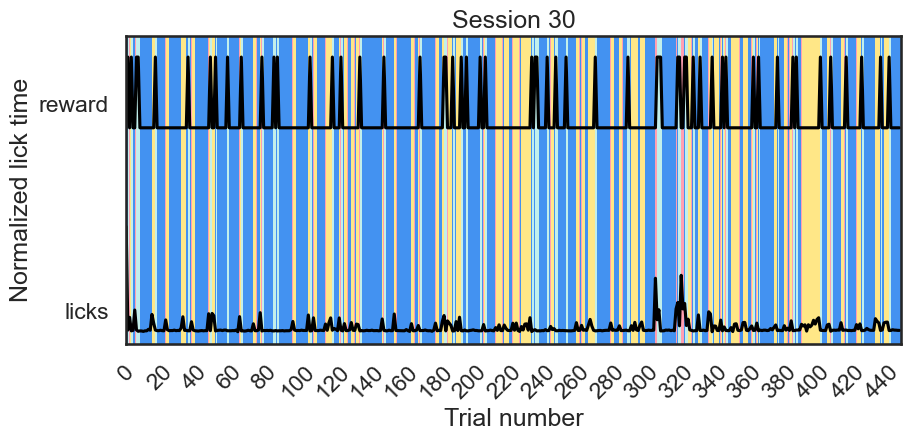

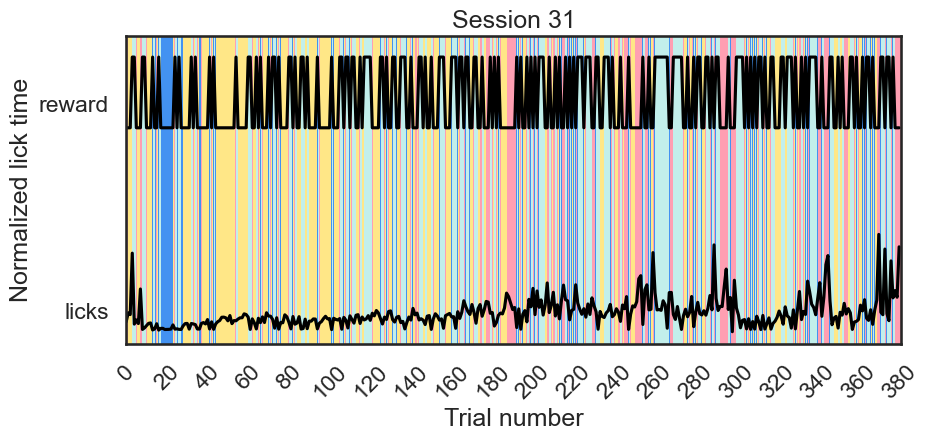

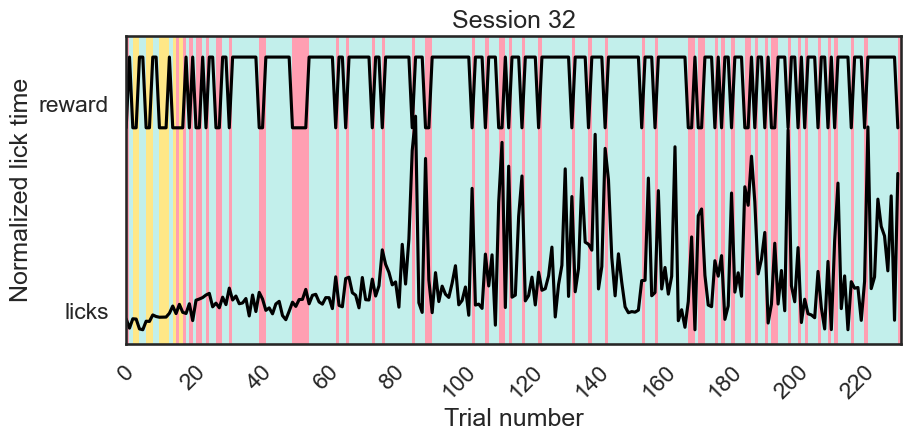

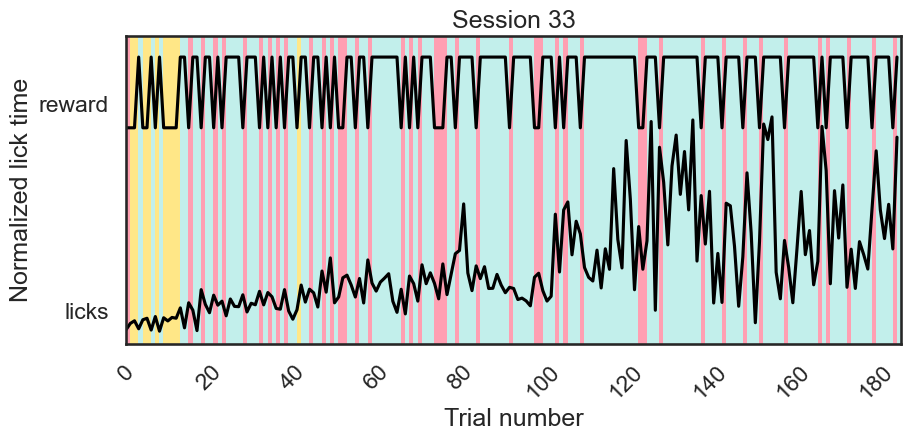

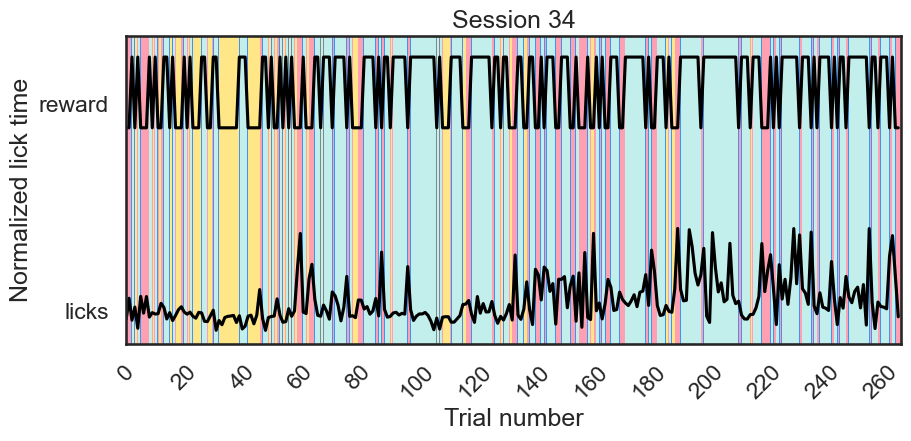

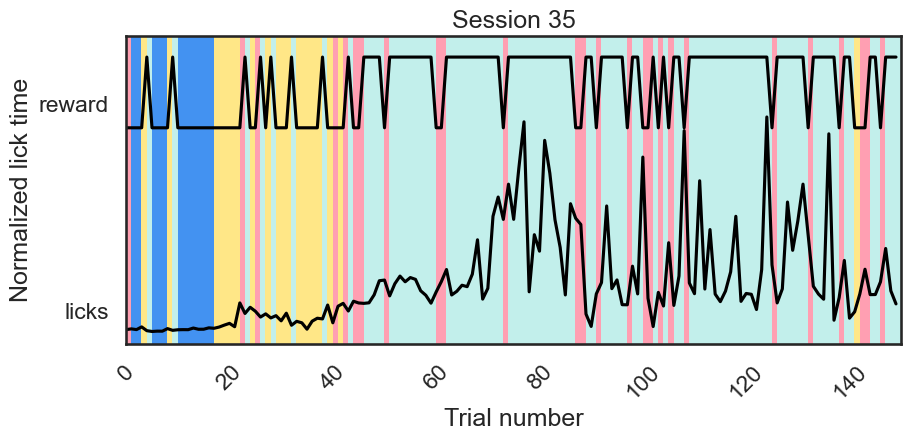

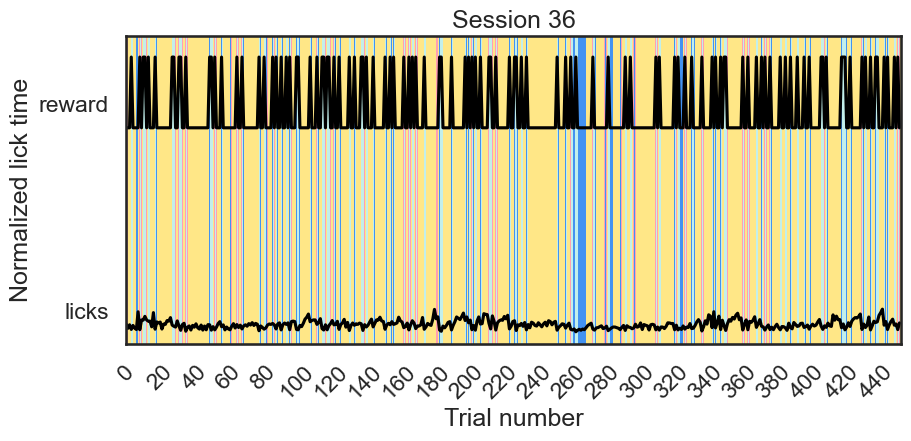

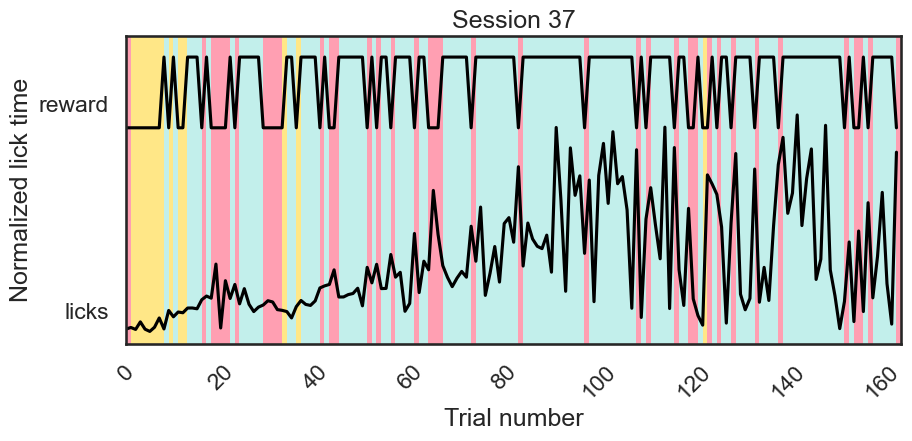

In [12]:
chosen_state_num = 4
save_to_df = True
df_mouse = df_individual_session[df_individual_session['mouse'] == mouse]

# for chosen_state_num in states:
    # model = models[states.index(chosen_state_num)]  
model = models[states.index(chosen_state_num)]      
session_start_idx = 0

new_row = []
for session in df_mouse['session']:
    rows = df_mouse.loc[df_mouse['session'] == session]
    cohort = rows['cohort'].values[0]
    sess_cutoff = rows['session length'].values[0]
    session_end_idx = session_start_idx + sess_cutoff

    data_this_session = X[session_start_idx:session_end_idx,:]
    states_curr_session = model.most_likely_states(data_this_session)
    new_row.append(states_curr_session)
    state_num = max(states_curr_session)

    lim_up = 1.1 * (X).max()
    lim_down = 1.05*(X).min()
    session_start_idx = session_end_idx 

    sess_licks = rows['licktime'].values[0]
    # plt.subplots()
    # plt.scatter(np.arange(len(sess_licks)),sess_licks)
    # plt.title(f"Session {session} licks raw")
    # plt.ylim([0,30])

    # print(f'states num: {len(states_curr_session)} \n')
    # print(f'licks num: {len(sess_licks)} \n')
    assert(len(states_curr_session) == len(sess_licks))
    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax1.plot(data_this_session[:,0], '-k')
    ax1.plot(data_this_session[:,2] + lim, '-k')

    ax1.imshow(states_curr_session[None,:],
            aspect="auto",
            cmap=cmap_custom,
            vmin=0,
            vmax=len(color_two_states)-1,
            extent=(0, len(states_curr_session), -1, lim+2))

    # ax1.set_xlim(0, df_mouse['session length'].max())
    ax1.set_xlabel("Trial number")
    tick_position = lim * np.arange(2)
    plt.yticks(tick_position,["licks", "reward"])
    xticks = np.arange(0, len(states_curr_session), 20)
    plt.xticks(xticks,rotation = 45)
    # plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])
    ax1.set_ylim([-1,lim+2])
    ax1.set_title(f"Session {session}")
    ax1.set_ylabel("Normalized lick time")
    # plt.close()
if save_to_df:
    df_mouse.loc[:,f'{state_num+1} States'] = new_row


**Visualize transition matrix**

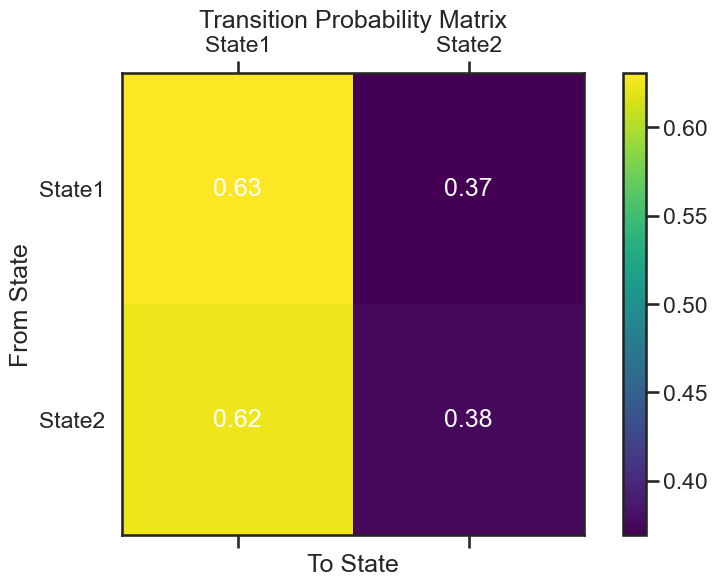

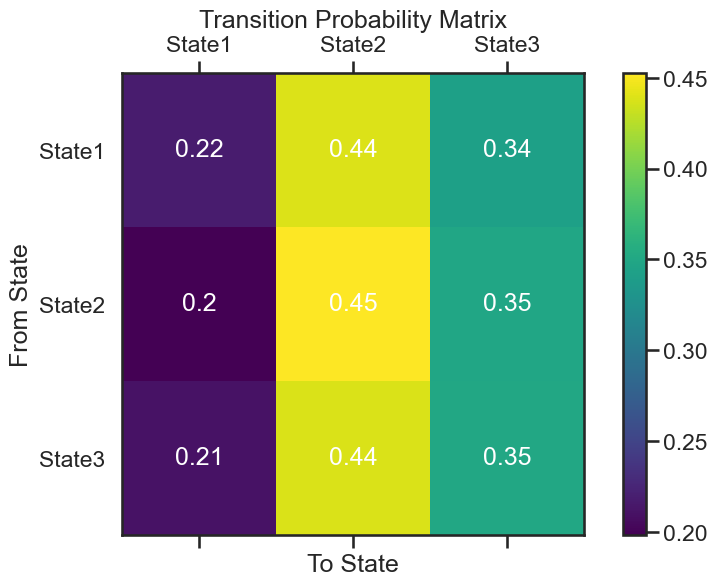

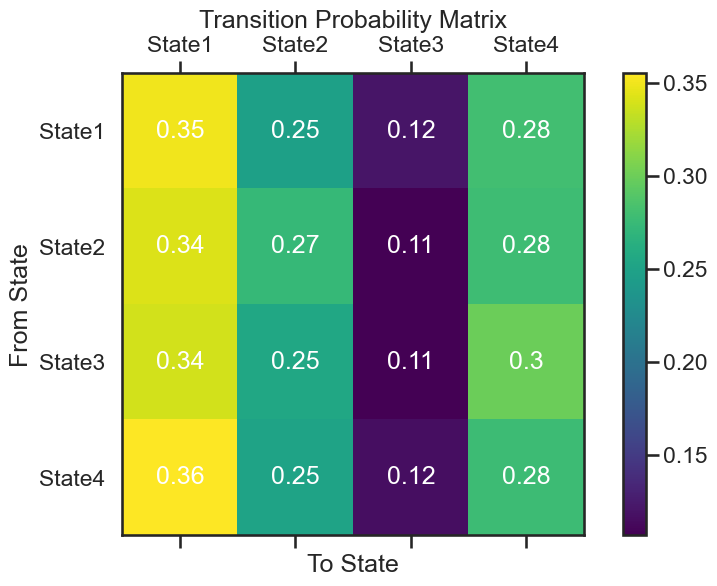

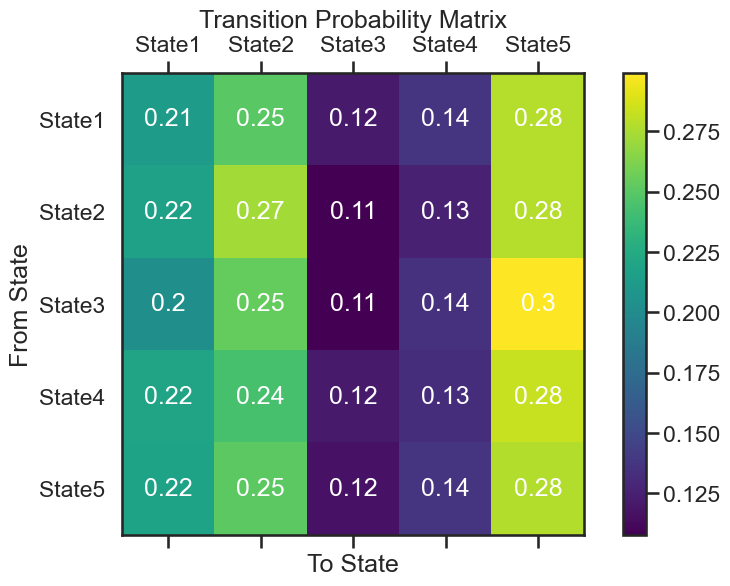

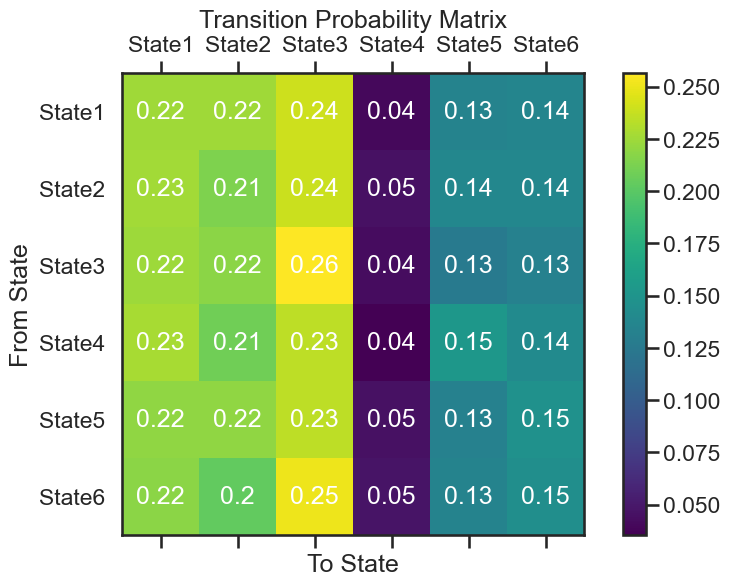

In [13]:
all_states = ['State1', 'State2', 'State3', 'State4', 'State5', 'State6',' ']
for i in range(len(models)):
            fig, ax = plt.subplots(figsize=(10,6))
            transition_matrix = models[i].transitions.transition_matrix
            cax = ax.matshow(transition_matrix, cmap='viridis')
            fig.colorbar(cax)
            curr_states = all_states[0:i+2]
            ax.set_xticks(np.arange(transition_matrix.shape[1]))
            ax.set_yticks(np.arange(transition_matrix.shape[0]))
            ax.set_xticklabels(curr_states)#, 'State 5'])
            ax.set_yticklabels(curr_states)#, 'State 5'])

            # Adding numbers to the matrix
            for a in range(transition_matrix.shape[0]):
                for b in range(transition_matrix.shape[1]):
                    text = ax.text(b, a, round(transition_matrix[a, b], 2),
                                ha="center", va="center", color="w")

            # Title and labels
            ax.set_xlabel('To State')
            ax.set_ylabel('From State')
            ax.set_title('Transition Probability Matrix')
      

**State occupancy overtime**

In [206]:
df_mouse

mouse cohort  session                                           licktime  \
259  ZG025  short        0  [2.168438196182251, 4.818650960922241, 0.75171...   
260  ZG025  short        1  [10.123501062393188, 0.3632748126983642, 10.13...   
261  ZG025  short        2  [1.1552891731262207, 1.5285956859588623, 0.263...   
262  ZG025  short        3  [15.075233936309814, 5.821568489074707, 0.5713...   
263  ZG025  short        4  [1.872563362121582, 0.9590795040130616, 0.0421...   
264  ZG025  short        5  [7.281971931457519, 18.08795666694641, 9.05325...   
265  ZG025  short        6  [4.040354490280151, 1.072483777999878, 0.38031...   
266  ZG025  short        7  [0.5084621906280518, 2.155648231506348, 3.5877...   
267  ZG025  short        8  [7.82276725769043, 3.683806419372559, 8.153721...   
268  ZG025  short        9  [8.764697790145874, 0.7330567836761475, 0.3823...   
269  ZG025  short       10  [7.068796157836914, 2.8381664752960205, 8.6504...   
270  ZG025  short       11  [0.5616140365600586, 1.2951972484588623, 0.730...   
271  ZG025  short       12  [19.07761573791504, 14.772281646728516, 7.0936...   
272  ZG025  short       13  [6.519768476486206, 4.171810865402222, 0.52268...   
273  ZG025  short       14  [1.8542723655700684, 3.3739514350891118, 1.094...   
274  ZG025  short       15  [14.060947895050049, 7.987608194351196, 0.2607...   
275  ZG025  short       16  [0.2205491065979004, 1.2263450622558594, 1.234...   
276  ZG025  short       17  [0.9897527694702148, 0.8909034729003906, 0.416...   
277  ZG025  short       18  [1.4827089309692385, 1.7566792964935305, 2.112...   
278  ZG025  short       19  [1.5301296710968018, 0.2538990974426269, 0.452...   
279  ZG025  short       20  [0.4743969440460205, 0.3461787700653076, 0.577...   
280  ZG025  short       21  [1.4084062576293943, 1.7147984504699707, 0.427...   
281  ZG025  short       22  [0.2869665622711181, 1.09271240234375, 0.29167...   
282  ZG025  short       23  [8.290370464324951, 5.189817190170288, 3.01020...   
283  ZG025  short       24  [6.93219256401062, 0.2130722999572754, 8.61372...   
284  ZG025  short       25  [0.27504563331604, 0.4182608127593994, 0.93837...   
285  ZG025  short       26  [2.237890243530273, 1.2676398754119873, 1.0067...   
286  ZG025  short       27  [0.5940117835998535, 0.4919474124908447, 0.798...   
287  ZG025  short       28  [5.3274688720703125, 0.4454743862152099, 0.447...   
288  ZG025  short       29  [9.434122562408447, 7.977014541625977, 7.26992...   
289  ZG025  short       30  [6.461172819137573, 4.280724763870239, 7.55152...   
290  ZG025  short       31  [6.114051342010498, 0.3597619533538818, 0.2515...   
291  ZG025  short       32  [0.7886021137237549, 1.5713791847229004, 1.140...   
292  ZG025  short       33  [10.098890542984009, 5.220875024795532, 0.4572...   

                                         previous lick  \
259  [0, 2.168438196182251, 4.818650960922241, 0.75...   
260  [0, 10.123501062393188, 0.3632748126983642, 10...   
261  [0, 1.1552891731262207, 1.5285956859588623, 0....   
262  [0, 15.075233936309814, 5.821568489074707, 0.5...   
263  [0, 1.872563362121582, 0.9590795040130616, 0.0...   
264  [0, 7.281971931457519, 18.08795666694641, 9.05...   
265  [0, 4.040354490280151, 1.072483777999878, 0.38...   
266  [0, 0.5084621906280518, 2.155648231506348, 3.5...   
267  [0, 7.82276725769043, 3.683806419372559, 8.153...   
268  [0, 8.764697790145874, 0.7330567836761475, 0.3...   
269  [0, 7.068796157836914, 2.8381664752960205, 8.6...   
270  [0, 0.5616140365600586, 1.2951972484588623, 0....   
271  [0, 19.07761573791504, 14.772281646728516, 7.0...   
272  [0, 6.519768476486206, 4.171810865402222, 0.52...   
273  [0, 1.8542723655700684, 3.3739514350891118, 1....   
274  [0, 14.060947895050049, 7.987608194351196, 0.2...   
275  [0, 0.2205491065979004, 1.2263450622558594, 1....   
276  [0, 0.9897527694702148, 0.8909034729003906, 0....   
277  [0, 1.4827089309692385, 1.7566792964935305, 2....   
278  [0, 

In [207]:
trial_state

array([3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 3, 0, 3, 3, 3, 3,
       0, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 0, 0, 2, 0, 0, 0, 0, 3, 0, 3,
       3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 3,
       3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       3, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 2, 3, 0, 3, 0, 0, 3, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       3, 3, 0, 3, 0, 0, 0, 0, 0, 3])

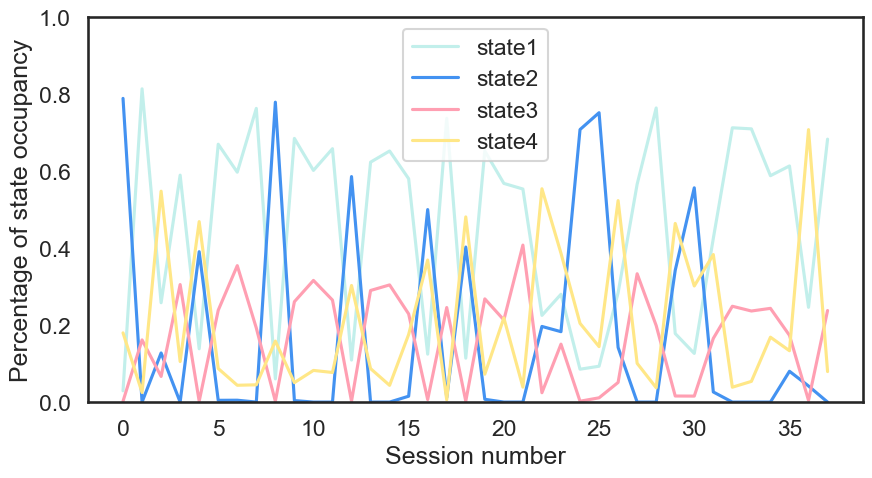

In [14]:
# states = [2,3,4,5,6]
states = [4]
state_occupancy = []

for state in states:
    state_occupancy = []
    for session in df_mouse['session']:
        rows = df_mouse.loc[df_mouse['session'] == session]
        trial_state = rows[f'{state} States'].values[0]
        sess_length = len(trial_state)
        temp = []
        for i in range(state):
            temp.append(list(trial_state).count(i)/sess_length)
        state_occupancy.append(temp)         
    fig, ax = plt.subplots(figsize=(10, 5))
    for this_state in range(len(state_occupancy[0])):
        this_state_occ = [sublist[this_state] for sublist in state_occupancy]
        ax.plot(this_state_occ,color =cmap_custom(this_state))
    ax.legend(['state1', 'state2', 'state3', 'state4','state5', 'state6'])
    ax.set_xlabel('Session number')
    ax.set_ylabel('Percentage of state occupancy')  
    ax.set_ylim([0,1])


**Mean, STD and CV of each state**

In [17]:
for state in states:
    session_mean = []
    session_std = []
    session_cv = []
    for session in df_mouse['session']:
        rows = df_mouse.loc[df_mouse['session'] == session]
        trial_state = rows[f'{state} States'].values[0]
        sess_licks = rows['licktime'].values[0]
        # sess_licks = sess_licks[1:]
        mean_ = []
        std_ = []
        cv_ = []
        for i in range(state):
            indices = [j for j, x in enumerate(trial_state) if x == i]
            state_licks = [sess_licks[i] for i in indices]
            mean_.append(np.nanmean(state_licks))
            std_.append(np.nanstd(state_licks))
            coeff_var = [(x / y )* 100for x, y in zip(std_, mean_)]
            cv_.append(coeff_var)
        session_mean.append(mean_)  
        session_std.append(std_)  
        session_cv.append(cv_)  
    


/Users/cecelia/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/cecelia/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cecelia/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/cecelia/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/cecelia/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Satet 1 average: 4.15
Satet 2 average: 0.26
Satet 3 average: 6.18
Satet 4 average: 1.72


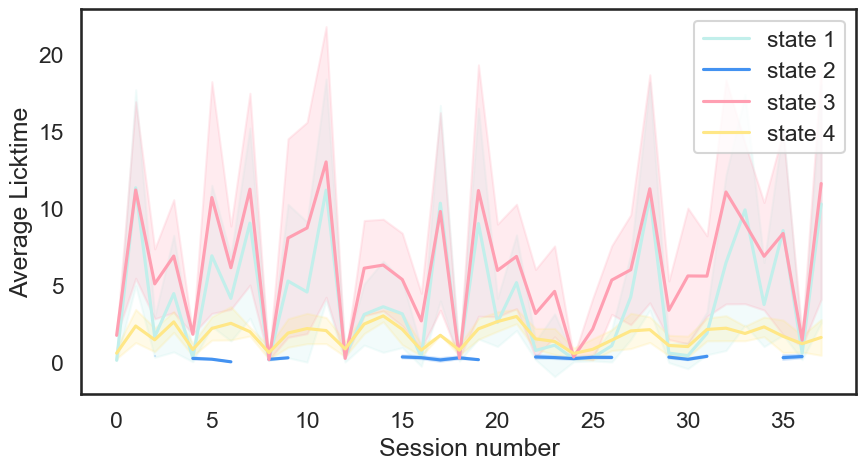

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 5))

for state_num in range(4):
    state_mean = [sublist[state_num] for sublist in session_mean]
    state_std = [sublist_[state_num] for sublist_ in session_std]
    ax1.plot(state_mean,color =cmap_custom(state_num),label=f'state {state_num+1}')
    ax1.fill_between(range(len(state_mean)), np.array(state_mean) - np.array(state_std), np.array(state_mean) + np.array(state_std), color =cmap_custom(state_num), alpha=0.2)
    ax1.legend()
    ax1.set_xlabel('Session number')
    ax1.set_ylabel('Average Licktime')  
    print(f'Satet {state_num+1} average: {np.nanmean(state_mean,):.2f}')